**Find Trends in the data for modeling forward pass**

Similar to `experiments/step_time_analysis.ipynb` we are using current batch data we gathered in profiling to estimate forward pass times with a model

In [15]:
import os
# split the largesweep folder into smaller ones, train and test. Around 70% of the data is used for training and 30% for testing. Copy the files to the respective folders.
import shutil       
import random
def split_largesweep_folder(base_path, train_ratio=0.7, test_ratio=0.3):
    # Create train and test directories
    train_dir = os.path.join(base_path, 'train')
    test_dir = os.path.join(base_path, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Delete the train and test directories if they exist, then recreate them
    for folder in [train_dir, test_dir]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder, exist_ok=True)

    # List all files in the base directory (ignore subfolders)
    all_files = [f for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]
    
    # Shuffle files for randomness
    random.shuffle(all_files)
    
    total = len(all_files)
    num_train = int(total * train_ratio)
    num_test = int(total * test_ratio)
    
    # Ensure no overlap and don't exceed available files
    train_files = all_files[:num_train]
    test_files = all_files[num_train:num_train+num_test]
    
    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(base_path, file), os.path.join(train_dir, file))
        
    for file in test_files:
        shutil.copy(os.path.join(base_path, file), os.path.join(test_dir, file))

split_largesweep_folder('profiling/execution-data/largesweep', train_ratio=0.7, test_ratio=0.3)


In [16]:
from utils import parse_csv, format_data, concatenate_dataframes # found in utils.py

path1 = 'profiling/execution-data/largesweep/train/'

# # parse and concat all dataframes
df = concatenate_dataframes(path1)
df = format_data(df)
df.head()

,num_total_scheduled_tokens,loop_time,loop_step_time,loop_queue_time,execute_time,scheduler_time,update_time,arrival_rate,time_stamp,sum_cached_prefill_tokens,max_cached_prefill_tokens,num_prefills,sum_decode_tokens,sum_uncached_prefill_tokens,max_uncached_prefill_tokens,sum_prefill_tokens,max_prefill_tokens,num_total_requests
0,64,0.015146,0.006298,0.008848,0.006164,0.000120,0.000010,64,-0.008611,0,0,1,0,64,64,64,64,1
1,73,0.008164,0.006195,0.001969,0.006037,0.000082,0.000035,64,0.006535,0,0,2,0,73,64,73,64,2
2,65,0.007259,0.006181,0.001078,0.006062,0.000063,0.000035,64,0.014699,0,0,1,1,64,64,64,64,2
3,65,0.007050,0.006073,0.000976,0.005957,0.000061,0.000033,64,0.021958,0,0,1,1,64,64,64,64,2
4,65,0.007126,0.006206,0.000920,0.006091,0.000059,0.000034,64,0.029008,0,0,1,1,64,64,64,64,2


In [17]:
def manual_predict(sum_decode_tokens, sum_prefill_tokens, max_prefill_tokens, num_prefills):
    # Your coefficients (in order of the features)
    coef = [3.41298094e-05, 4.15316658e-06, 2.86339254e-06, 
            1.65335979e-03, 5.11182987e-08, -9.48056285e-08, 1.86501432e-07, 
            2.24889167e-05, -7.77693854e-09, 3.21956881e-08, 6.28999508e-06, 
            -1.72890630e-08, -9.60619427e-06, -6.28061729e-04]

    intercept = 0.00568775493503766
    
    # Calculate each polynomial feature
    features = [
        sum_decode_tokens,
        sum_prefill_tokens, 
        max_prefill_tokens,
        num_prefills,
        sum_decode_tokens**2,
        sum_decode_tokens * sum_prefill_tokens,  
        sum_decode_tokens * max_prefill_tokens,
        sum_decode_tokens * num_prefills,
        sum_prefill_tokens**2,
        sum_prefill_tokens * max_prefill_tokens,  
        sum_prefill_tokens * num_prefills,
        max_prefill_tokens**2,
        max_prefill_tokens * num_prefills,
        num_prefills**2
    ]
    
    # Dot product of coefficients and features, plus intercept
    prediction = intercept + sum(c * f for c, f in zip(coef, features))
    return prediction

In [18]:
# train a polynomial regression model to predict execute_time based on num_prefills, sum_decode_tokens, sum_prefill_tokens, and arrival_rate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[['sum_decode_tokens', 'sum_uncached_prefill_tokens', 'max_uncached_prefill_tokens','num_prefills']]
y = df['execute_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
degree = 2 # You can change the degree of the polynomial

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)
print("Polynomial Model Score:", poly_model.score(X_test, y_test))

coefficients = poly_model.named_steps['linearregression'].coef_
intercept = poly_model.named_steps['linearregression'].intercept_
print("Polynomial Coefficients:", str(coefficients))
print("Polynomial Intercept:", intercept)

Polynomial Model Score: 0.9308970524695284
Polynomial Coefficients: [ 0.00000000e+00  4.29457908e-05  1.32742879e-05 -5.39382272e-06
  1.64539882e-04  4.55100279e-08  1.67622486e-08  1.20466352e-07
  2.47965016e-06  2.60209494e-09 -1.00133429e-08 -3.26463654e-07
  7.73080154e-09 -3.70684738e-07 -8.03421694e-06]
Polynomial Intercept: 0.0056702534775332145


Test Score: 0.9639341561184934


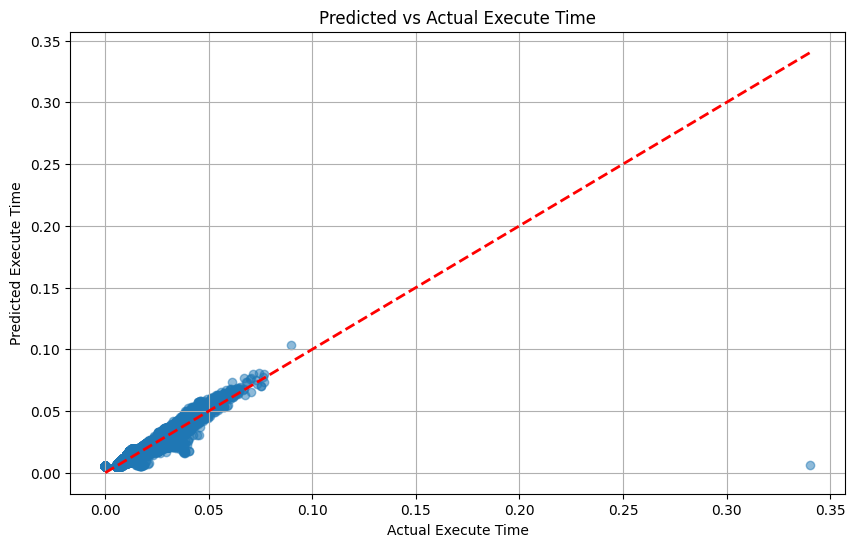

In [19]:
path1 = 'profiling/execution-data/largesweep/test/'

# # parse and concat all dataframes
df_test = concatenate_dataframes(path1)
df_test = format_data(df_test)
df_test.head()

X_test = df_test[['sum_decode_tokens', 'sum_uncached_prefill_tokens', 'max_uncached_prefill_tokens','num_prefills']]
y_test = df_test['execute_time']

# score
score = poly_model.score(X_test, y_test)
print("Test Score:", score)

# plot the predicted vs actual execute_time
import matplotlib.pyplot as plt
import numpy as np

predicted = poly_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Execute Time')
plt.ylabel('Predicted Execute Time')
plt.title('Predicted vs Actual Execute Time')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(True)
plt.show()

In [20]:
# get avg schedule, update, queue overhead times
print("Step scheduler time", df['scheduler_time'].mean())
print("Step update time", df['update_time'].mean())
print("Loop queue time", df['loop_queue_time'].median())


Step scheduler time 0.00013359797632081508
Step update time 6.731279422011643e-05
Loop queue time 0.0014365119859576


In [21]:
# get avg schedule, update, queue overhead times
print("Step scheduler time", df_test['scheduler_time'].mean())
print("Step update time", df_test['update_time'].mean())
print("Loop queue time", df_test['loop_queue_time'].median())


Step scheduler time 0.00012767954601645453
Step update time 6.529814929096664e-05
Loop queue time 0.0014391150325536
